In [16]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def demand_sales_dgp(
    rng_key: ArrayImpl, n: int
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl, ArrayImpl, ArrayImpl]:
    t = jnp.arange(start=0, stop=n, step=1)
    demand = 2 * jnp.ones_like(t, dtype=jnp.float32)
    sales = jnp.zeros_like(t, dtype=jnp.float32)
    sales_obs = jnp.zeros_like(t, dtype=jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    noise_demand = 0.3 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    noise_sales = 0.5 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    is_available = random.bernoulli(rng_subkey, 0.9, shape=(t.size,)).astype(
        jnp.float32
    )

    for i in range(2, t.size):
        demand_i = (
            0.6 * demand[i - 1]
            + 0.3 * demand[i - 2]
            + 0.5 * jnp.sin(2 * jnp.pi * t[i] / 7)
            + 0.2
            + noise_demand[i]
        )
        demand_i = jnp.maximum(demand_i, 0)
        demand = demand.at[i].set(demand_i)  # noqa

        sales_i = demand[i] + noise_sales[i] - 0.2
        sales_i = jnp.minimum(sales_i, demand_i)
        sales_i = jnp.maximum(sales_i, 0)
        sales_i_obs = is_available[i] * sales_i
        sales_i_obs = jnp.minimum(sales_i_obs, 2.3)
        sales = sales.at[i].set(sales_i)  # noqa
        sales_obs = sales_obs.at[i].set(sales_i_obs)  # noqa

    return t, demand, sales, sales_obs, is_available


n = 200
rng_key, rng_subkey = random.split(rng_key)
t, demand, sales, sales_obs, is_available = demand_sales_dgp(rng_subkey, n)

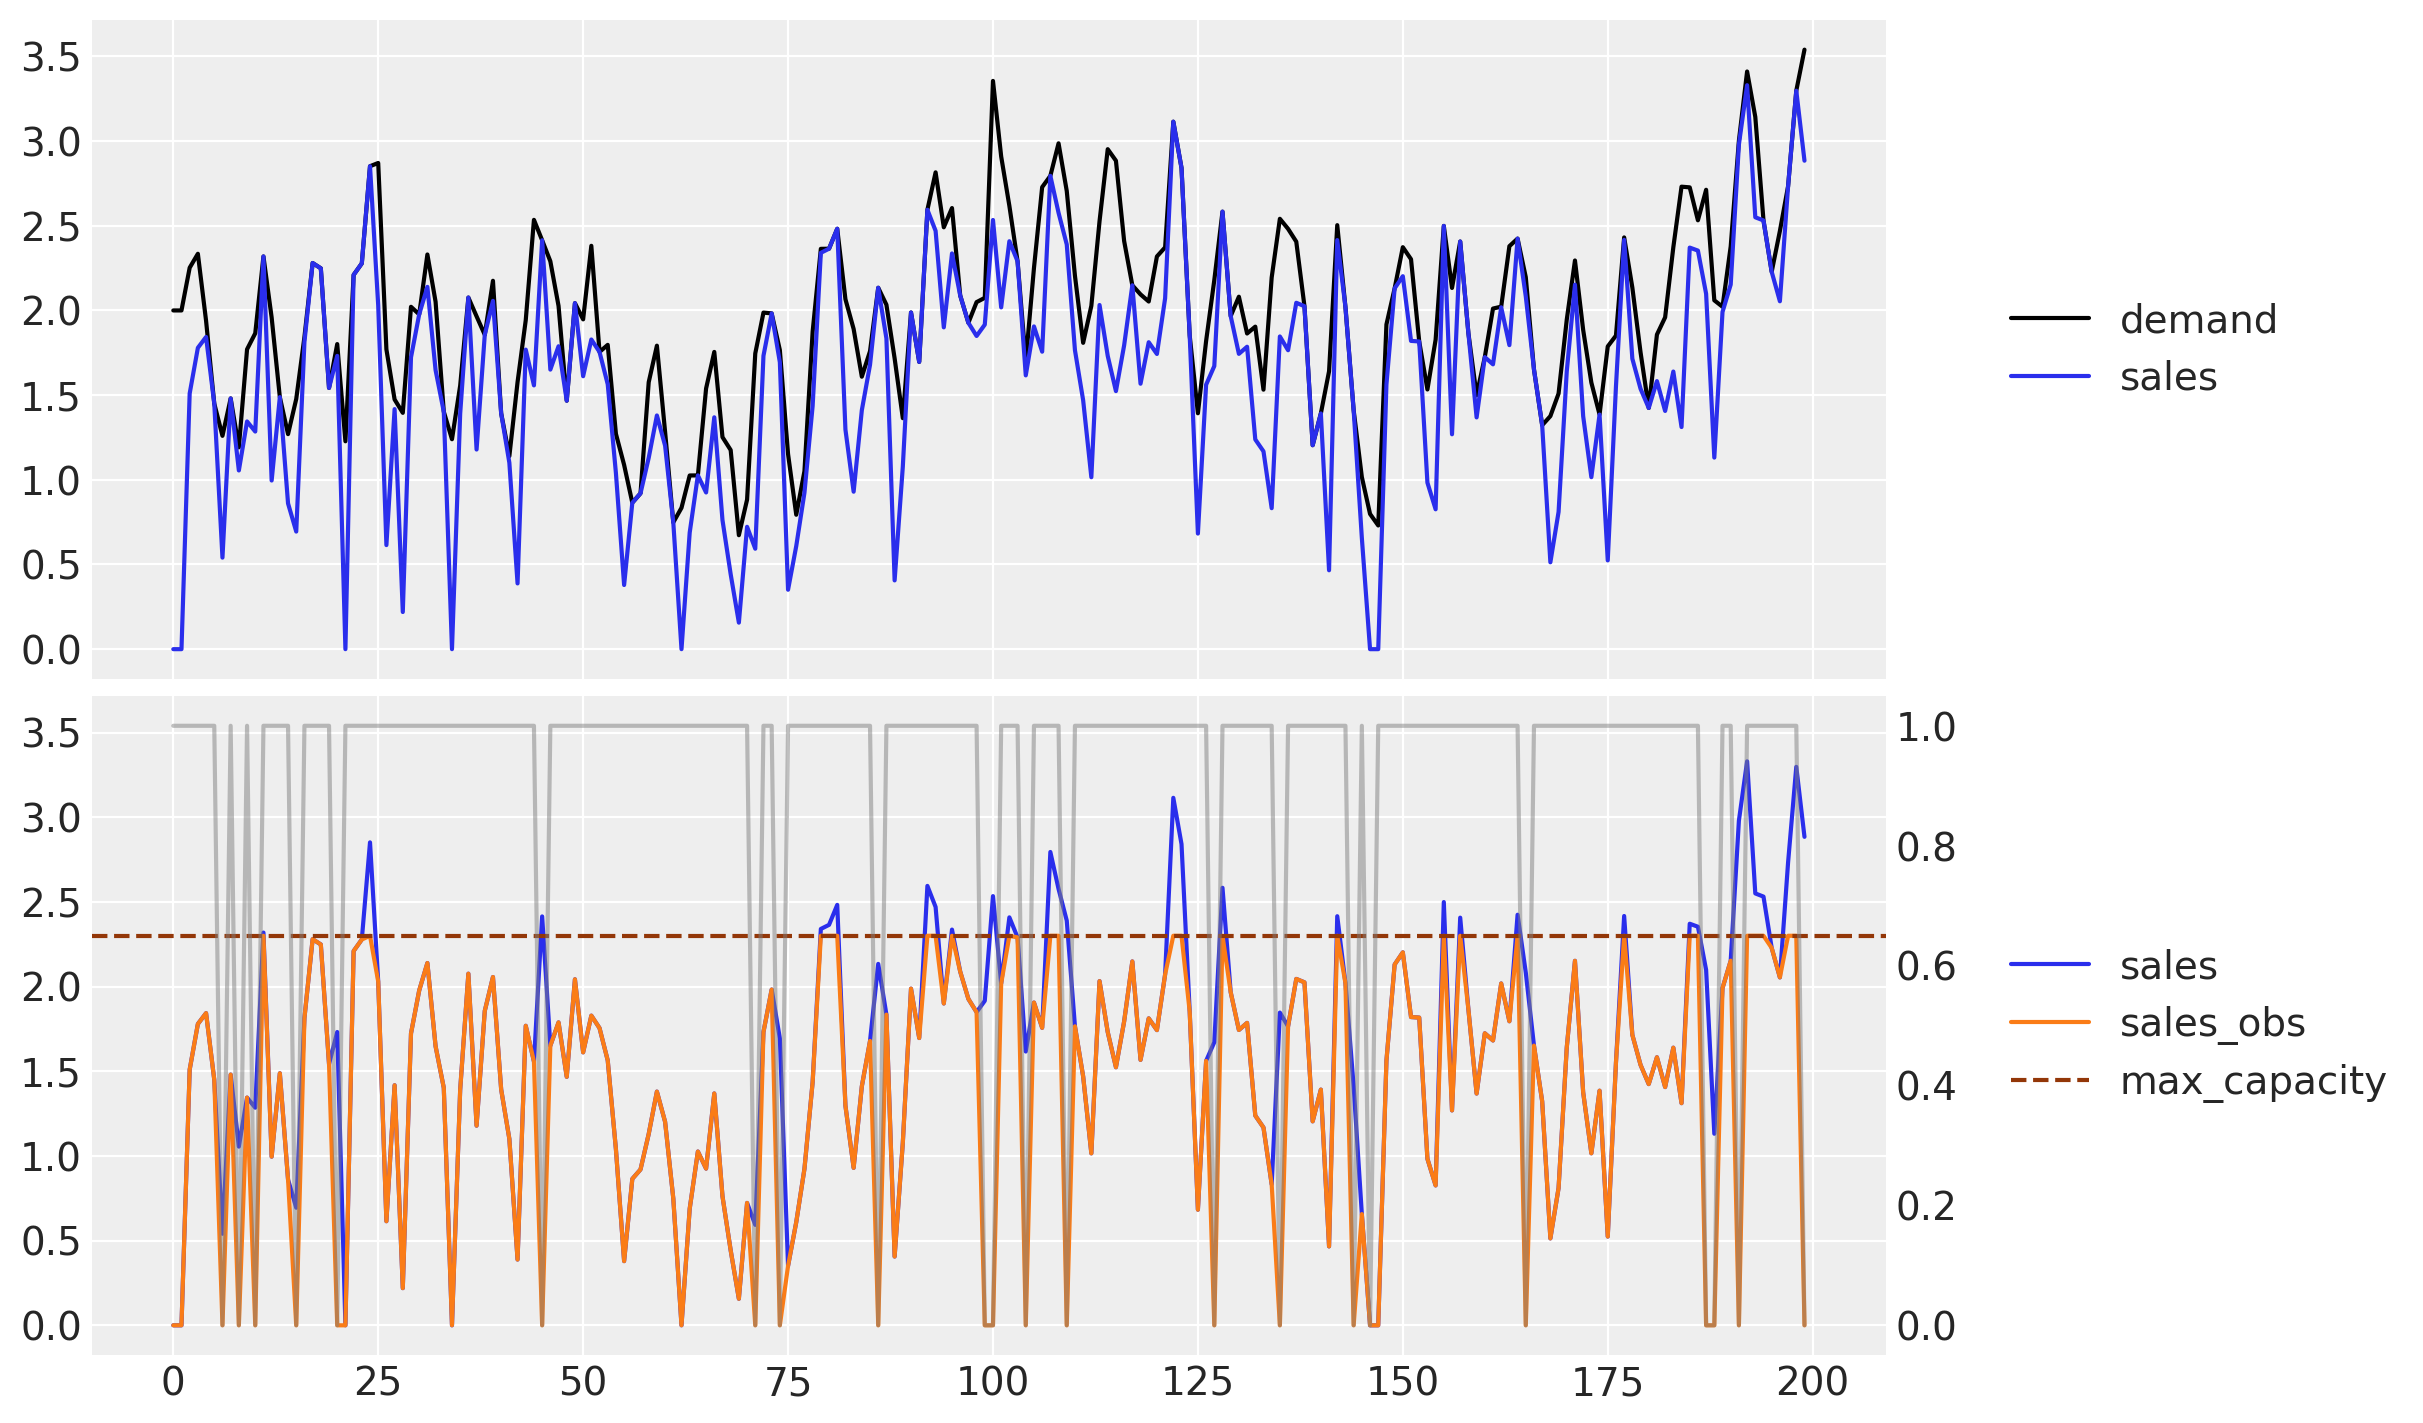

In [17]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].plot(t, demand, c="black", label="demand")
ax[0].plot(t, sales, c="C0", label="sales")
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

ax[1].plot(t, sales, c="C0", label="sales")
ax[1].plot(t, sales_obs, c="C1", label="sales_obs")
ax1_twin = ax[1].twinx()
ax1_twin.plot(t, is_available, c="gray", alpha=0.5, label="is_available")
ax[1].axhline(2.3, color="C4", linestyle="--", label="max_capacity")
ax1_twin.grid(None)
ax[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5));

In [4]:
forecast_horizon = 15

t_train = t[:-forecast_horizon]
demand_train = demand[:-forecast_horizon]
sales_train = sales[:-forecast_horizon]
sales_obs_train = sales_obs[:-forecast_horizon]
is_available_train = is_available[:-forecast_horizon]

t_test = t[-forecast_horizon:]
demand_test = demand[-forecast_horizon:]
sales_test = sales[-forecast_horizon:]
sales_obs_test = sales_obs[-forecast_horizon:]
is_available_test = is_available[-forecast_horizon:]
is_available_test_expected = jnp.ones_like(is_available_test)

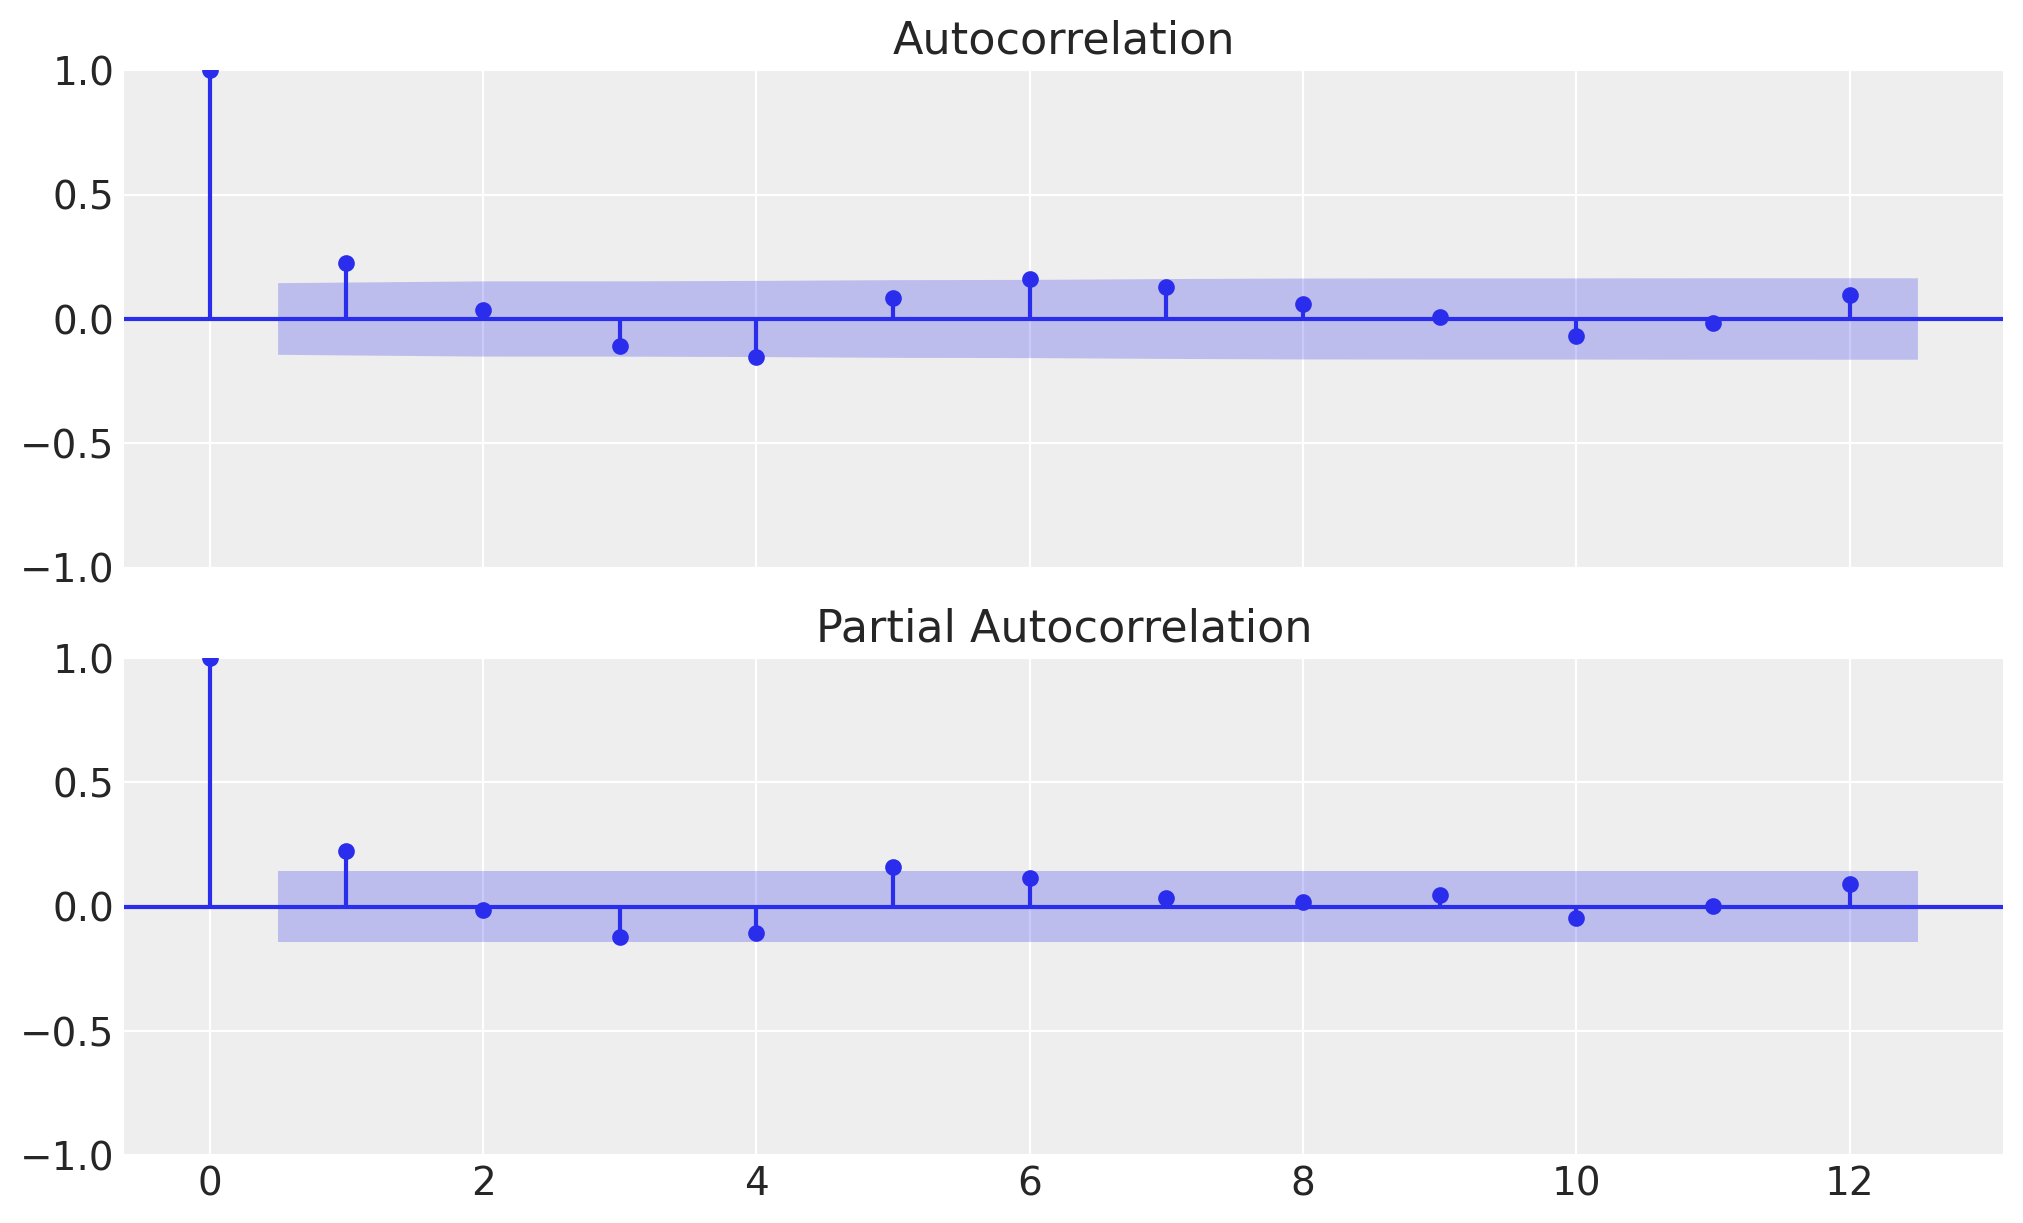

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 6), layout="constrained"
)

_ = plot_acf(sales_obs_train, lags=12, ax=ax[0])
_ = plot_pacf(sales_obs_train, lags=12, ax=ax[1])

In [6]:
model = ARIMA(
    endog=np.asarray(sales_obs_train),
    exog=is_available_train,
    order=(2, 0, 0),
    # seasonal_order=(1, 1, 0, 7),
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  185
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -147.412
Date:                Mon, 15 Apr 2024   AIC                            304.824
Time:                        16:48:09   BIC                            320.926
Sample:                             0   HQIC                           311.350
                                - 185                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0074      0.235      0.031      0.975      -0.454       0.468
x1             1.4952      0.215      6.941      0.000       1.073       1.917
ar.L1          0.3963      0.073      5.434      0.000       0.253       0.539
ar.L2         -0.0246      0.079     -0.310      0.756      -0.180       0.131
sigma2         0.2879      0.033      8.721      0.000       0.223       0.353
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                12.49
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.62
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

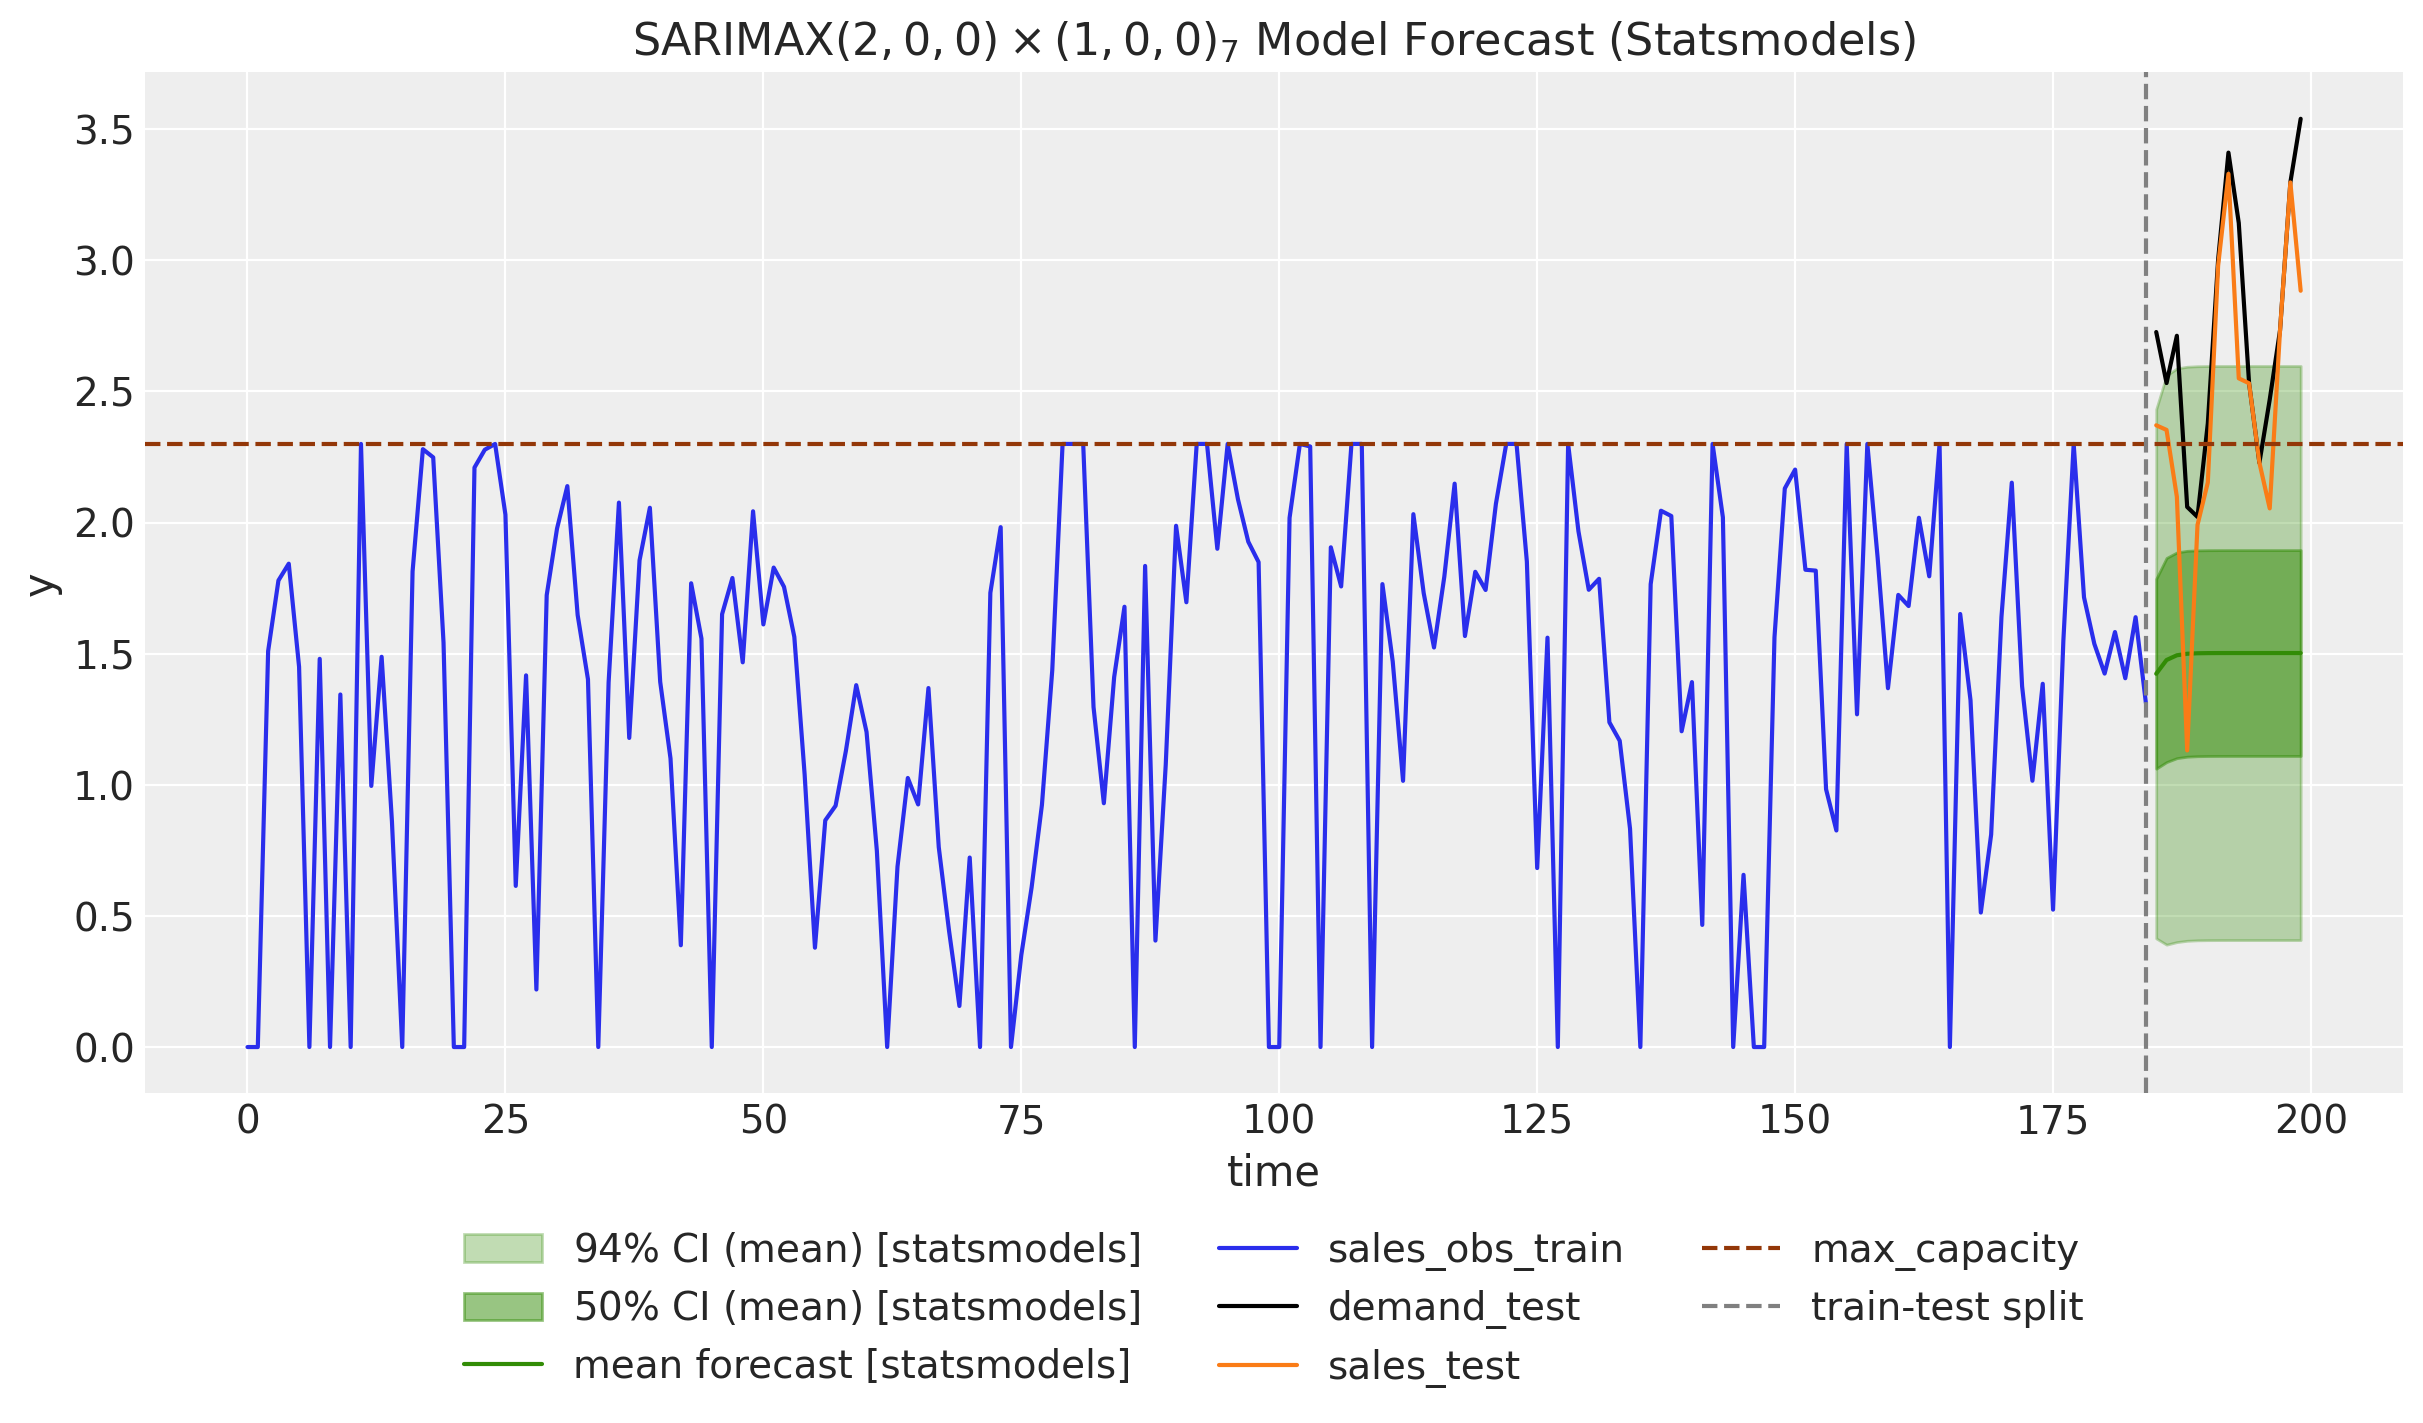

In [7]:
forecast_94_df = result.get_forecast(
    steps=sales_obs_test.size, exog=is_available_test_expected
).summary_frame(alpha=0.06)

forecast_50_df = result.get_forecast(
    steps=sales_obs_test.size, exog=is_available_test_expected
).summary_frame(alpha=0.5)

fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_94_df["mean_ci_lower"],
    forecast_94_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.fill_between(
    t_test,
    forecast_50_df["mean_ci_lower"],
    forecast_50_df["mean_ci_upper"],
    color="C2",
    alpha=0.5,
    label=r"$50\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_94_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", label="demand_test")
ax.plot(t_test, sales_test, color="C1", label="sales_test")
ax.axhline(y=2.3, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(
    xlabel="time",
    ylabel="y",
    title="SARIMAX$(2, 0, 0)\\times(1, 0, 0)_{7}$ Model Forecast (Statsmodels)",
);

In [8]:
def ar2_seasonal(y: ArrayImpl, future: int = 0) -> None:
    t_max = y.size
    mu = numpyro.sample("mu", dist.Normal(loc=1, scale=1))
    phi_1 = numpyro.sample("phi_1", dist.Uniform(low=-1, high=1))
    phi_2 = numpyro.sample("phi_2", dist.Uniform(low=-1, high=1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    def transition_fn(carry, t):
        y_prev_1, y_prev_2 = carry
        ar_part = phi_1 * y_prev_1 + phi_2 * y_prev_2
        pred_mean = mu + ar_part
        pred = numpyro.sample("pred", dist.Normal(loc=pred_mean, scale=sigma))
        return (pred, y_prev_1), pred

    init = (y[1], y[0])
    timesteps = jnp.arange(t_max - 2 + future)

    with numpyro.handlers.condition(data={"pred": y[2:]}):
        _, preds = scan(transition_fn, init, timesteps)

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

In [9]:
sampler = NUTS(ar2_seasonal, target_accept_prob=0.90)
mcmc = MCMC(sampler, num_warmup=2_000, num_samples=2_000, num_chains=4)
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_key=rng_subkey, y=sales_obs_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [10]:
idata = az.from_numpyro(posterior=mcmc)

print(f"Divergences: {idata.sample_stats.diverging.sum().item()}")

Divergences: 0


In [11]:
idata = az.from_numpyro(
    posterior=mcmc, coords={"t_train": t_train[2:]}, dims={"pred": ["t_train"]}
)

var_names = ["mu", "phi_1", "phi_2", "sigma"]

az.summary(data=idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.101,0.137,0.839,1.357,0.002,0.001,4320.0,4432.0,1.0
phi_1,0.212,0.076,0.069,0.355,0.001,0.001,4625.0,4456.0,1.0
phi_2,-0.011,0.074,-0.153,0.129,0.001,0.001,5209.0,4777.0,1.0
sigma,0.716,0.038,0.649,0.789,0.000,0.000,6127.0,4437.0,1.0


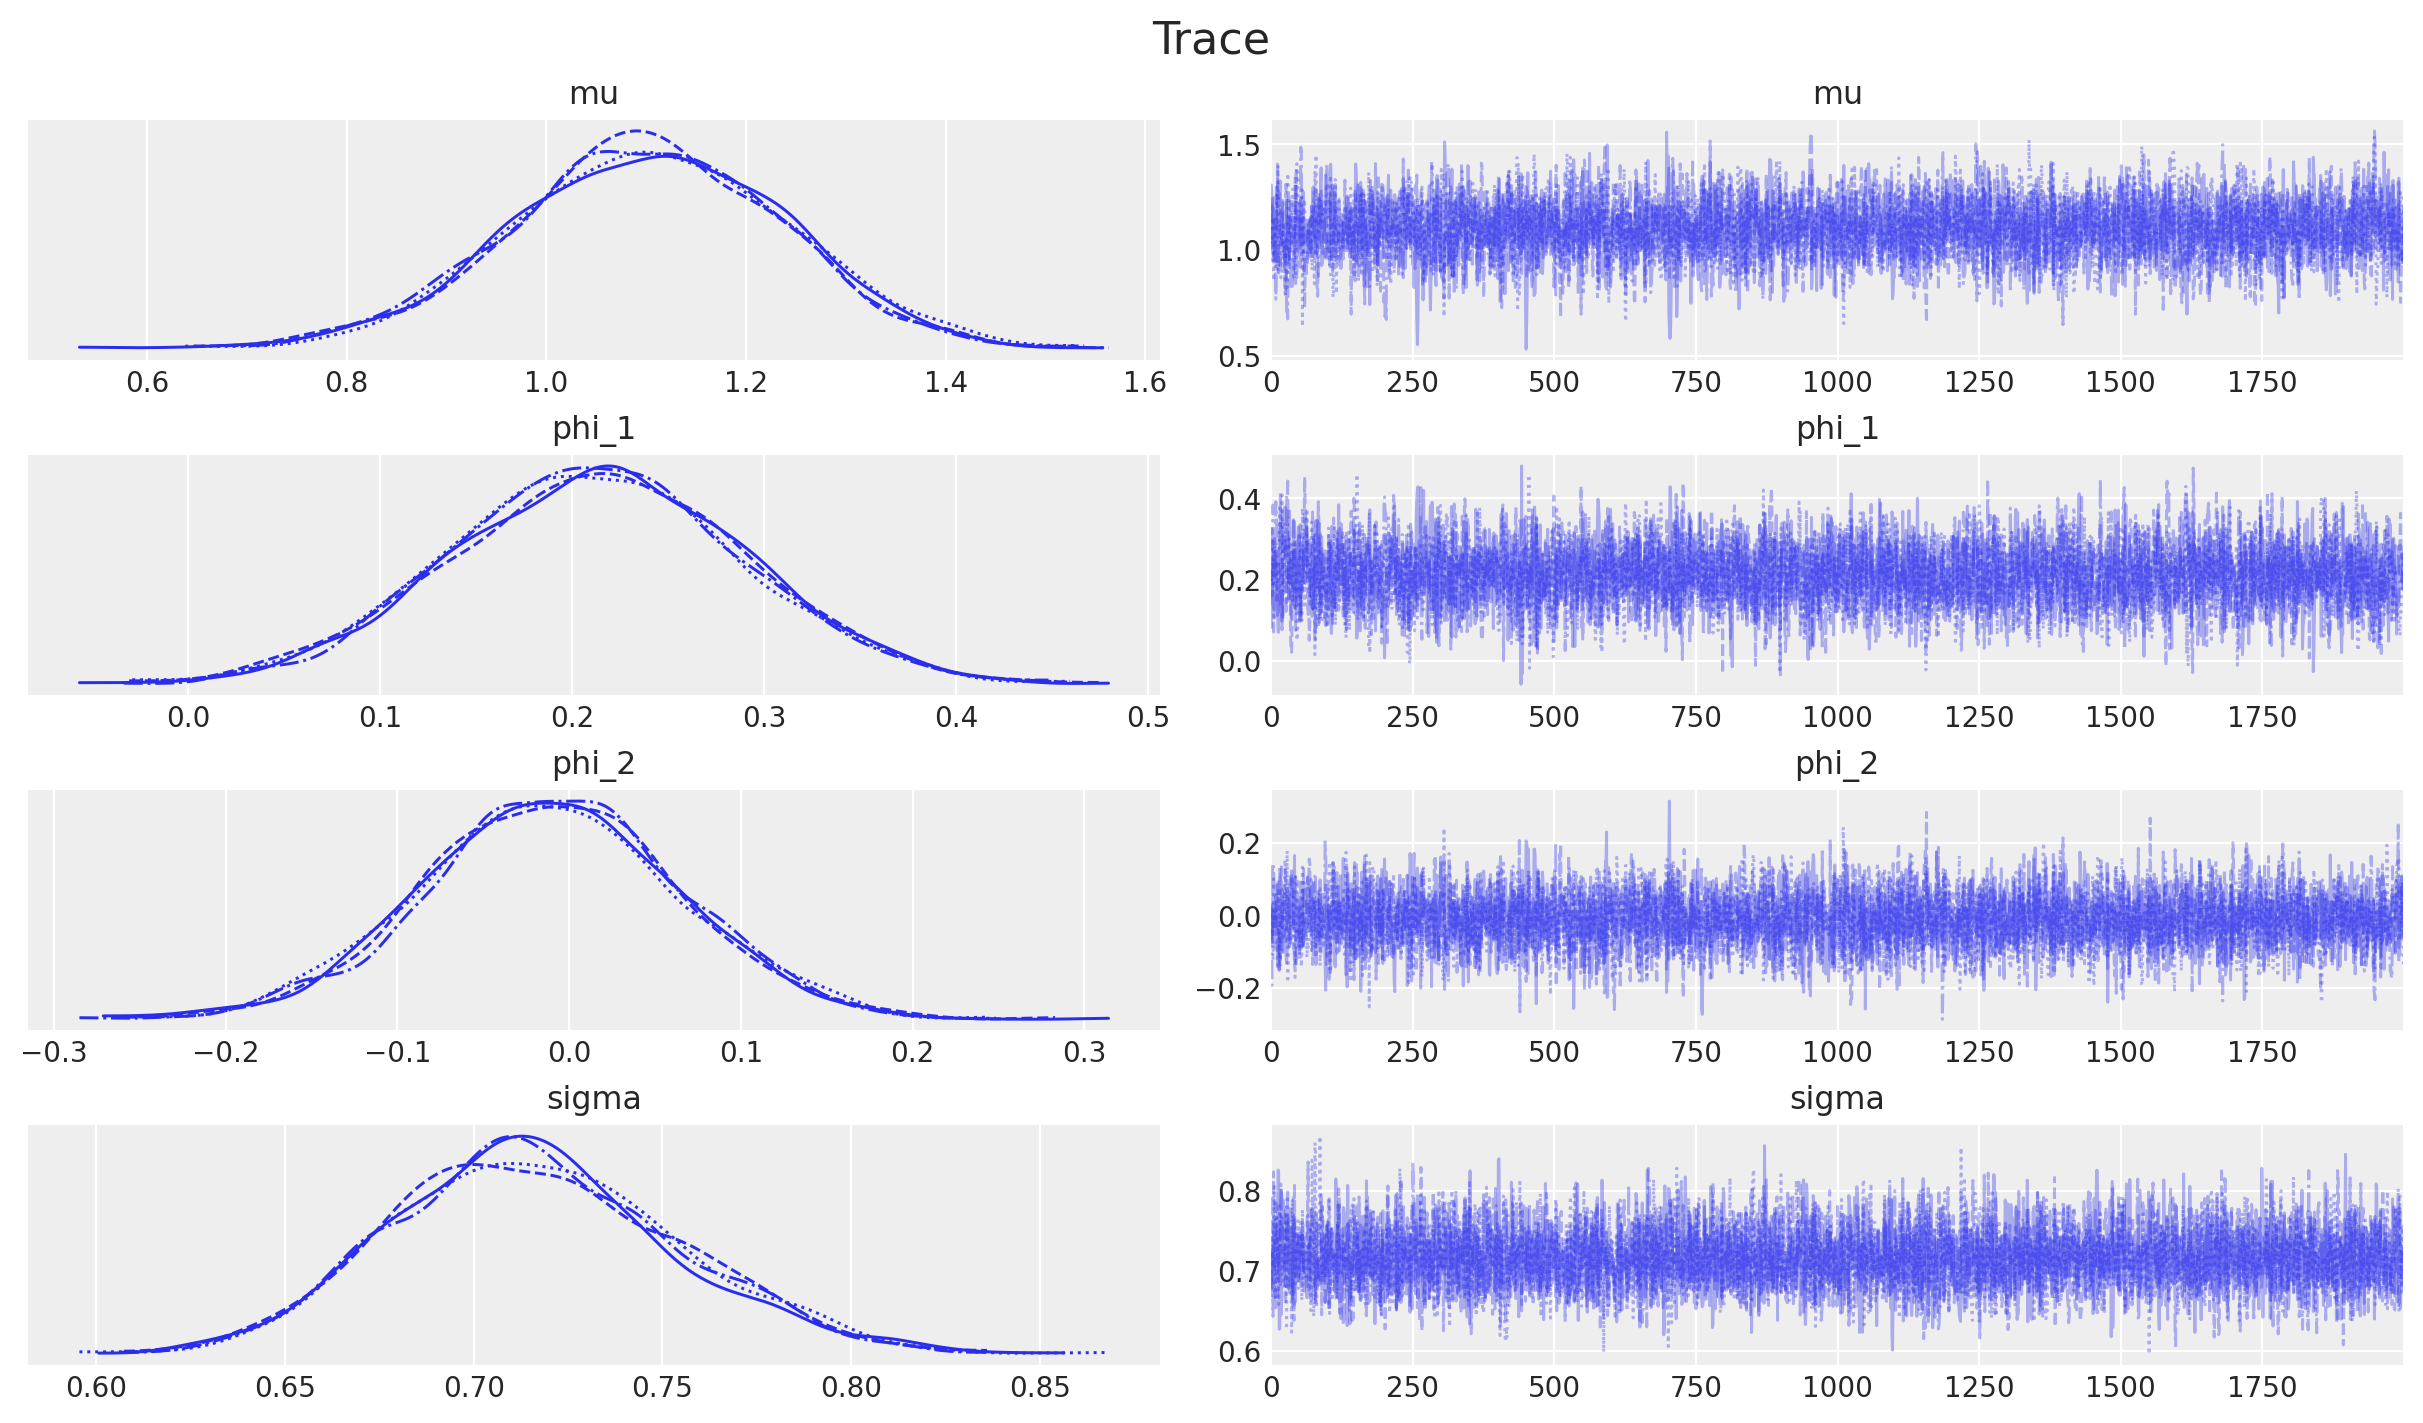

In [12]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16);

In [13]:
predictive = Predictive(
    model=ar2_seasonal,
    posterior_samples=mcmc.get_samples(),
    return_sites=["y_forecast"],
)
rng_key, rng_subkey = random.split(rng_key)
forecast = predictive(rng_subkey, y=sales_obs_train, future=forecast_horizon)

In [14]:
idata.extend(
    az.from_numpyro(
        posterior_predictive=forecast,
        coords={"t_test": t_test, "t": t},
        dims={"y_forecast": ["t_test"]},
    )
)

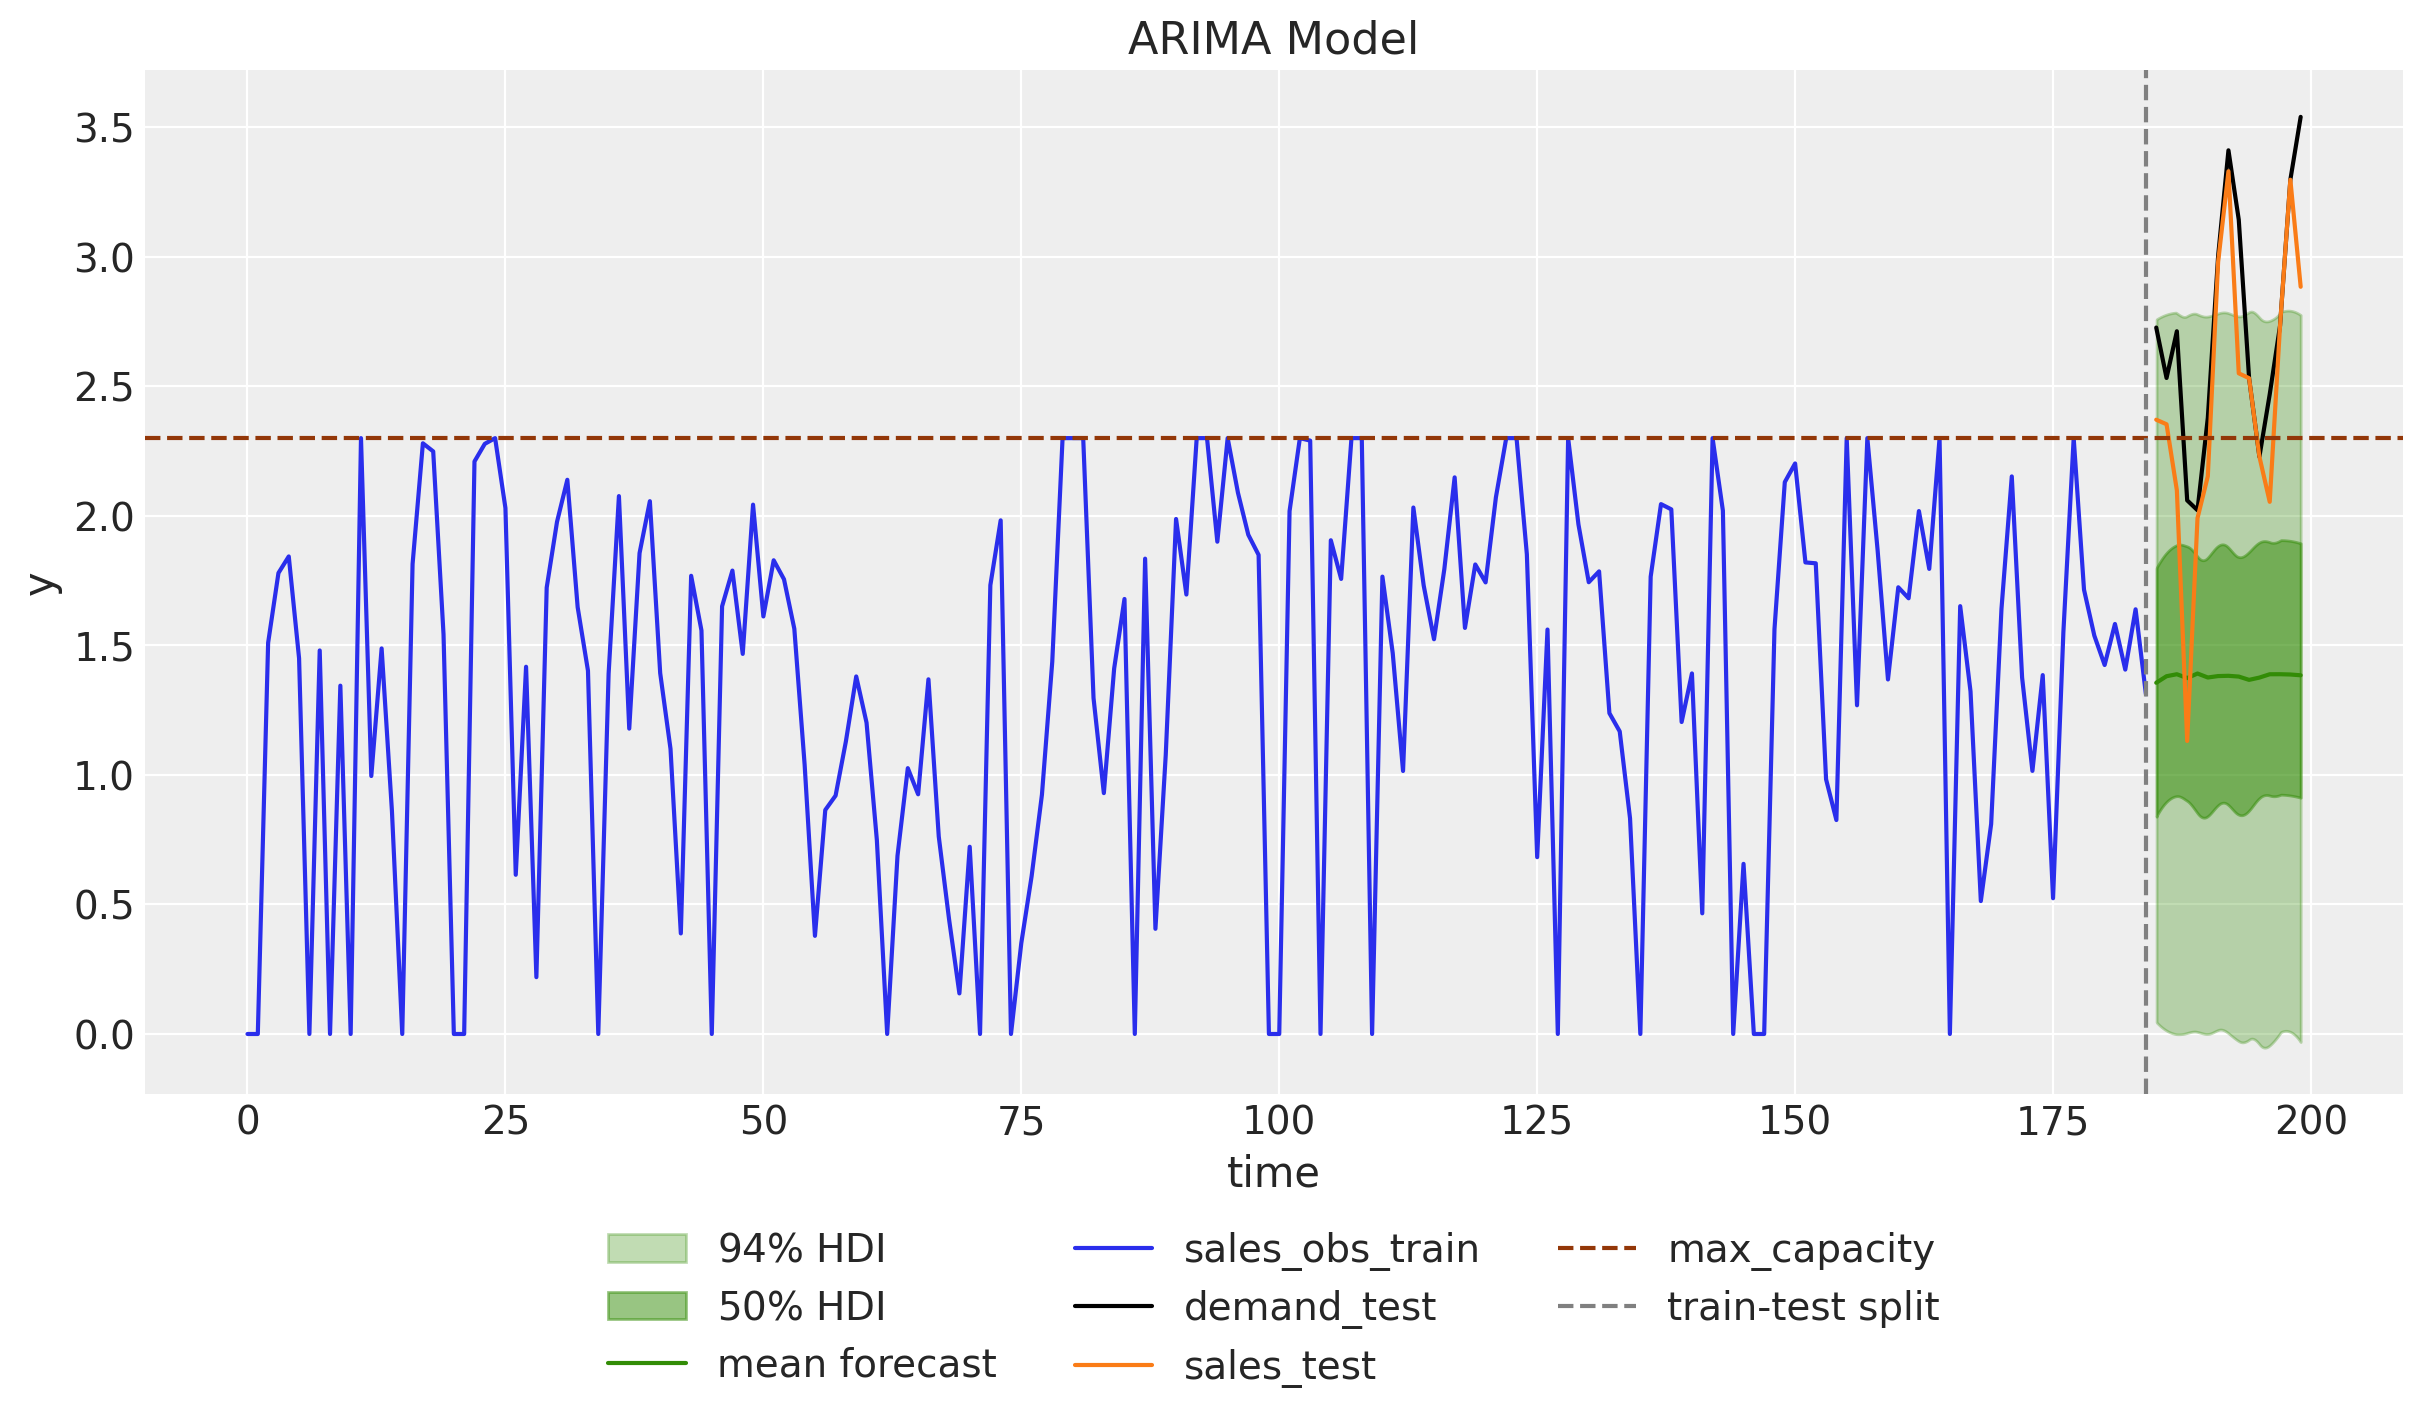

In [15]:
fig, ax = plt.subplots()
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
)
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
)
ax.plot(
    t_test,
    idata.posterior_predictive["y_forecast"].mean(dim=("chain", "draw")),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", label="demand_test")
ax.plot(t_test, sales_test, color="C1", label="sales_test")
ax.axhline(y=2.3, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="time", ylabel="y", title="ARIMA Model");